# Ensemble Methods Analysis

*Load in the following files:*



```
english-v1.h5                     # the model
fivegram_lexicon_all_prob.json
sixgram_lexicon_all_prob.json
newsData.txt                      # both as the test data for now
playData.txt
encoded_chars.npy                 # the np array for the lstm
```



## 0. Data Preprocessing Methods

### Methods to read in and process test data

In [6]:
import string
import re

def read_test_data(filename):
    translator = str.maketrans('', '', string.punctuation)

    with open(filename, 'r', encoding='utf-8') as file:
        contents = [line.strip().translate(translator).lower() for line in file.readlines()]
    return ''.join(contents)


In [7]:
def format_to_fivegram(contents):
    res = [contents[i:i+5] for i in range(len(contents)-4)]
    return res

def format_to_sixgram(contents):
    res = [contents[i:i+6] for i in range(len(contents)-5)]
    return res

def clean_text_for_lstm(text):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    cleaned_text = cleaned_text.lower()
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    return cleaned_text

def format_to_lstm(contents, seq_length=20):
    res = [contents[i:i+20] for i in range(len(contents)-19)]
    return res

In [8]:
data = read_test_data('newsData.txt') # + read_test_data('playData.txt')
data[:10]
# example

'german car'

## 1. Fivegram and Sixgram

### Mounting Fivegram and Sixgram lexicons

In [9]:
import json

with open("fivegram_lexicon_all_prob.json", "r") as file:
    fivegram_model = json.load(file)

with open("sixgram_lexicon_all_prob.json", "r") as file:
    sixgram_model = json.load(file)

### Inspecting models

In [10]:
fivegram_model[' so ']
# checking that the probabilities are all ordered from highest to lowest

[['t', 0.175],
 ['m', 0.104],
 ['i', 0.083],
 ['p', 0.073],
 ['a', 0.068],
 ['c', 0.065],
 ['s', 0.053],
 ['f', 0.052],
 ['d', 0.044],
 ['b', 0.043],
 ['e', 0.037],
 ['r', 0.033],
 ['o', 0.032],
 ['l', 0.03],
 ['h', 0.02],
 ['w', 0.018],
 ['g', 0.017],
 ['n', 0.015],
 ['u', 0.012],
 ['v', 0.011],
 ['q', 0.006],
 ['k', 0.006],
 ['j', 0.002],
 ['y', 0.0],
 [' ', 0.0],
 ['x', 0.0],
 ['z', 0.0]]

In [11]:
sixgram_model["*****"]

[['s', 0.159], ['a', 0.107], ['m', 0.094], ['p', 0.093], ['c', 0.087]]

### Individual Lexicons

In [12]:
def evaluate_fivegram(text, fivegram_model, formatted = False, output_set_size=5):
    if not formatted:
        datapoints = format_to_fivegram(text)

    correct_predictions = 0
    total_predictions = 0

    for sequence in datapoints:
        X = sequence[:4]
        y = sequence[4]

        if X in fivegram_model:
            total_predictions += 1

            yhat = [pred[0] for pred in fivegram_model[X][:output_set_size]]
            yhat_probabilities = [pred[1] for pred in fivegram_model[X][:output_set_size]]

            if y in yhat:
                correct_predictions += 1

    accuracy = correct_predictions / total_predictions

    return (accuracy, total_predictions, correct_predictions)

evaluate_fivegram(
    read_test_data('playData.txt'),
    fivegram_model,
    output_set_size=5
)

(0.7989523310633839, 124085, 99138)

In [13]:
def evaluate_sixgram(text, sixgram_model, formatted = False, output_set_size=5):
    """
    NB: there is no difference increasing the output_set_size past 5 for the sixgram, as each entry has only 5.
    """
    if not formatted:
        datapoints = format_to_sixgram(text)

    correct_predictions = 0
    total_predictions = 0

    for sequence in datapoints:
        X = sequence[:5]
        y = sequence[5]

        total_predictions += 1

        if X in sixgram_model:
            total_predictions += 1

            yhat = [pred[0] for pred in sixgram_model[X][:output_set_size]]
            yhat_probabilities = [pred[1] for pred in sixgram_model[X][:output_set_size]]

            if y in yhat:
                correct_predictions += 1

    accuracy = correct_predictions / total_predictions

    # print(f'Total predictions: {total_predictions}')

    return (accuracy, total_predictions, correct_predictions)

evaluate_sixgram(
    data,
    sixgram_model,
    output_set_size=5
)

(0.39540072078256394, 5827, 2304)

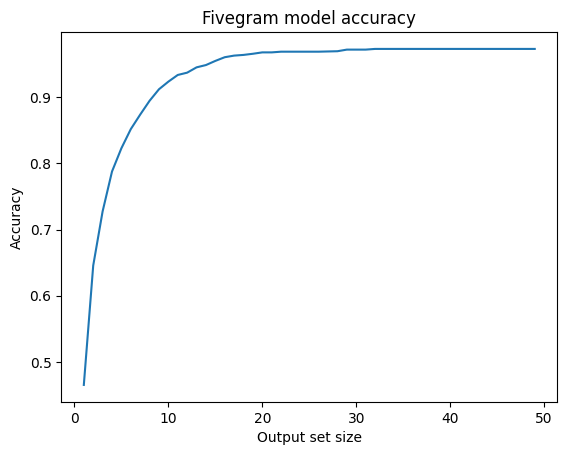

In [14]:
import matplotlib.pyplot as plt

fivegram_plot_data = [(i, evaluate_fivegram(
    data,
    fivegram_model,
    output_set_size=i
)[0]) for i in range(1, 50)]

x_vals, y_vals_fivegram = zip(*fivegram_plot_data)

plt.plot(x_vals, y_vals_fivegram)
plt.xlabel('Output set size')
plt.ylabel('Accuracy')
plt.title('Fivegram model accuracy')
plt.show()

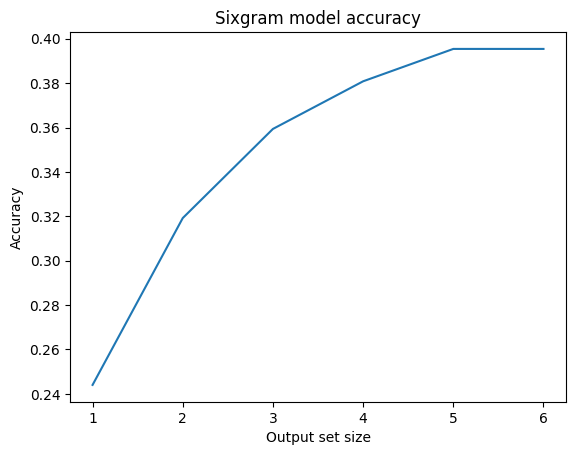

In [15]:
sixgram_plot_data = [(i, evaluate_sixgram(
    data,
    sixgram_model,
    output_set_size=i
)[0]) for i in range(1, 7)]

x_vals, y_vals_sixgram = zip(*sixgram_plot_data)

plt.plot(x_vals, y_vals_sixgram)
plt.xlabel('Output set size')
plt.ylabel('Accuracy')
plt.title('Sixgram model accuracy')
plt.show()

### Weighted Averaging

In [16]:
def evaluate_weighted_averaging_ensemble(
    text,
    fivegram_model,
    sixgram_model,
    output_set_size=5,
    weight_fivegram=0.5,
    weight_sixgram=0.5
):
    """
    NB: the data must NOT be formatted
    """

    # normalise weights
    total = weight_fivegram + weight_sixgram
    weight_fivegram /= total
    weight_sixgram /= total

    # format data
    datapoints = format_to_sixgram(text)

    correct_predictions = 0
    total_predictions = 0

    for sequence in datapoints:
        Xfivegram = sequence[1:5]
        Xsixgram = sequence[0:5]
        y = sequence[5]

        combined_probs = {}

        in_fivegram = Xfivegram in fivegram_model
        in_sixgram = Xsixgram in sixgram_model

        if not in_fivegram or in_sixgram:
            continue

        else:
            total_predictions += 1

            if in_fivegram and in_sixgram:
                data = fivegram_model[Xfivegram] + sixgram_model[Xsixgram]
                for i in range(len(data)):
                    if i < len(fivegram_model[Xfivegram]):
                        data[i].append('fivegram')
                    else:
                        data[i].append('sixgram')

            elif in_fivegram:
                data = fivegram_model[Xfivegram]
                for i in range(len(data)):
                    data[i].append('fivegram')

            else:
                data = sixgram_model[Xsixgram]
                for i in range(len(data)):
                    data[i].append('sixgram')

            for pred in data:
                if pred[0] not in combined_probs:
                    combined_probs[pred[0]] = 0

                if pred[2] == 'fivegram':
                    combined_probs[pred[0]] += weight_fivegram * pred[1]
                elif pred[2] == 'sixgram':
                    combined_probs[pred[0]] += weight_sixgram * pred[1]

            listed_probs = [(char, prob) for char, prob in combined_probs.items()]
            listed_probs = sorted(listed_probs, key=lambda x: x[1], reverse=True)

            yhat = [i[0] for i in listed_probs][:output_set_size]
            yhat_probabilities = [i[1] for i in listed_probs][:output_set_size]

            if y in yhat:
                correct_predictions += 1

    accuracy = correct_predictions / total_predictions

    # print(f'Total predictions: {total_predictions}')
    # print(f"Weighted Averaging Accuracy: {accuracy:.2%}")
    # print(f"Weights: Fivegram = {weight_fivegram:.2f}, Sixgram = {weight_sixgram:.2f}")

    return (accuracy, total_predictions, correct_predictions)

evaluate_weighted_averaging_ensemble(
    data,
    fivegram_model,
    sixgram_model,
    weight_fivegram=0.9,
    weight_sixgram=0.3
)

(0.625, 80, 50)

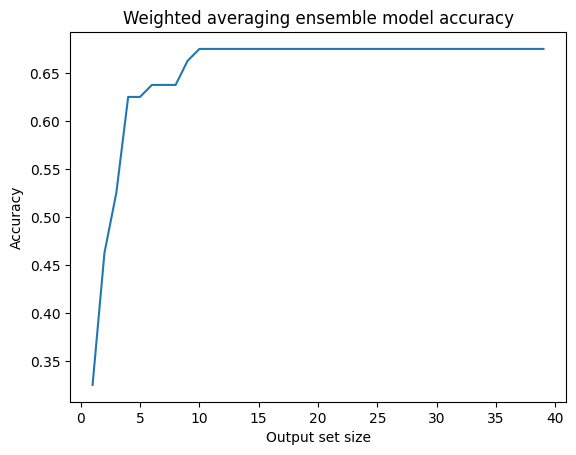

In [17]:
weighted_averaging_ensemble_plot_data = [(i, evaluate_weighted_averaging_ensemble(
    data,
    fivegram_model,
    sixgram_model,
    weight_fivegram=0.5,
    weight_sixgram=0,
    output_set_size=i
)[0]) for i in range(1, 40)]

x_vals, y_vals_weighted_averaging_ensemble = zip(*weighted_averaging_ensemble_plot_data)

plt.plot(x_vals, y_vals_weighted_averaging_ensemble)
plt.xlabel('Output set size')
plt.ylabel('Accuracy')
plt.title('Weighted averaging ensemble model accuracy')
plt.show()

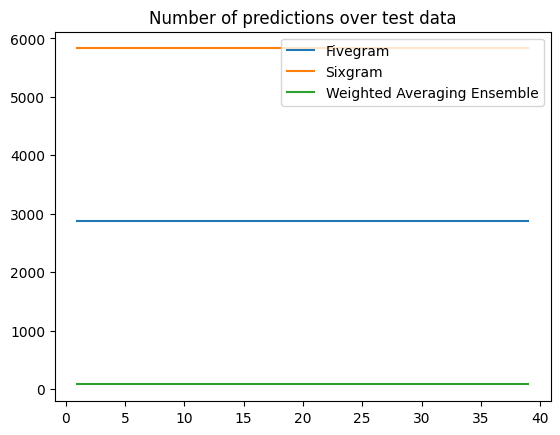

In [18]:
fivegram_plot_data = [(i, evaluate_fivegram(
    data,
    fivegram_model,
    output_set_size=i
)[1]) for i in range(1, 40)]

x_vals, y_vals_fivegram = zip(*fivegram_plot_data)

sixgram_plot_data = [(i, evaluate_sixgram(
    data,
    sixgram_model,
    output_set_size=i
)[1]) for i in range(1, 40)]

x_vals, y_vals_sixgram = zip(*sixgram_plot_data)

weighted_averaging_ensemble_plot_data = [(i, evaluate_weighted_averaging_ensemble(
    data,
    fivegram_model,
    sixgram_model,
    weight_fivegram=0.9,
    weight_sixgram=0.3,
    output_set_size=i
)[1]) for i in range(1, 40)]

x_vals, y_vals_weighted_averaging_ensemble = zip(*weighted_averaging_ensemble_plot_data)

plt.plot(x_vals, y_vals_fivegram, label='Fivegram')
plt.plot(x_vals, y_vals_sixgram, label='Sixgram')
plt.plot(x_vals, y_vals_weighted_averaging_ensemble, label='Weighted Averaging Ensemble')
plt.legend()
plt.title("Number of predictions over test data")

plt.show()

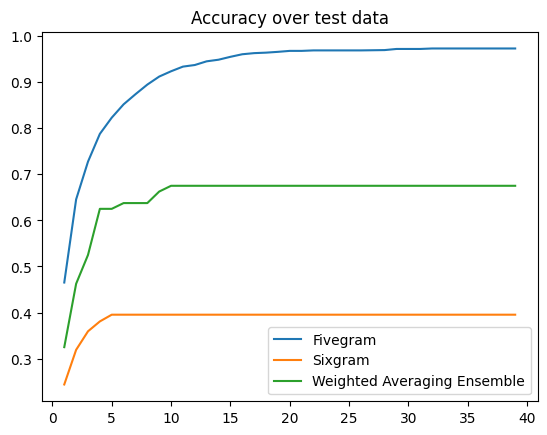

In [19]:
fivegram_plot_data = [(i, evaluate_fivegram(
    data,
    fivegram_model,
    output_set_size=i
)[0]) for i in range(1, 40)]

x_vals, y_vals_fivegram = zip(*fivegram_plot_data)

sixgram_plot_data = [(i, evaluate_sixgram(
    data,
    sixgram_model,
    output_set_size=i
)[0]) for i in range(1, 40)]

x_vals, y_vals_sixgram = zip(*sixgram_plot_data)

weighted_averaging_ensemble_plot_data = [(i, evaluate_weighted_averaging_ensemble(
    data,
    fivegram_model,
    sixgram_model,
    weight_fivegram=0.9,
    weight_sixgram=0.3,
    output_set_size=i
)[0]) for i in range(1, 40)]

x_vals, y_vals_weighted_averaging_ensemble = zip(*weighted_averaging_ensemble_plot_data)

plt.plot(x_vals, y_vals_fivegram, label='Fivegram')
plt.plot(x_vals, y_vals_sixgram, label='Sixgram')
plt.plot(x_vals, y_vals_weighted_averaging_ensemble, label='Weighted Averaging Ensemble')
plt.legend()
plt.title("Accuracy over test data")

plt.show()

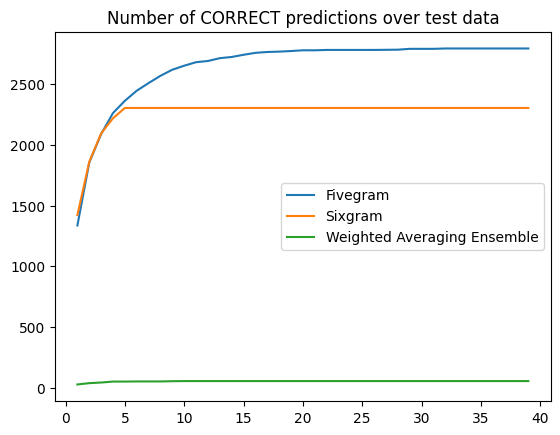

In [20]:
fivegram_plot_data = [(i, evaluate_fivegram(
    data,
    fivegram_model,
    output_set_size=i
)[2]) for i in range(1, 40)]

x_vals, y_vals_fivegram = zip(*fivegram_plot_data)

sixgram_plot_data = [(i, evaluate_sixgram(
    data,
    sixgram_model,
    output_set_size=i
)[2]) for i in range(1, 40)]

x_vals, y_vals_sixgram = zip(*sixgram_plot_data)

weighted_averaging_ensemble_plot_data = [(i, evaluate_weighted_averaging_ensemble(
    data,
    fivegram_model,
    sixgram_model,
    weight_fivegram=0.9,
    weight_sixgram=0.3,
    output_set_size=i
)[2]) for i in range(1, 40)]

x_vals, y_vals_weighted_averaging_ensemble = zip(*weighted_averaging_ensemble_plot_data)

plt.plot(x_vals, y_vals_fivegram, label='Fivegram')
plt.plot(x_vals, y_vals_sixgram, label='Sixgram')
plt.plot(x_vals, y_vals_weighted_averaging_ensemble, label='Weighted Averaging Ensemble')
plt.legend()
plt.title("Number of CORRECT predictions over test data")

plt.show()

### Voting

In [21]:
def evaluate_model_switching_ensemble(
    text,
    fivegram_model,
    sixgram_model,
    output_set_size=5
):
    """
    NB: the data must NOT be formatted
    """

    # format data
    datapoints = format_to_sixgram(text)

    correct_predictions = 0
    total_predictions = 0

    for sequence in datapoints:
        Xfivegram = sequence[1:5]
        Xsixgram = sequence[0:5]
        y = sequence[5]

        in_fivegram = Xfivegram in fivegram_model
        in_sixgram = Xsixgram in sixgram_model

        if not (in_fivegram or in_sixgram):
            continue

        else:
            total_predictions += 1

            if in_fivegram:

                yhat_fivegram = [pred[0] for pred in fivegram_model[Xfivegram][:output_set_size]]
                yhat_fivegram_probabilities = [pred[1] for pred in fivegram_model[Xfivegram][:output_set_size]]

            if in_sixgram:

                yhat_sixgram = [pred[0] for pred in sixgram_model[Xsixgram][:output_set_size]]
                yhat_sixgram_probabilities = [pred[1] for pred in sixgram_model[Xsixgram][:output_set_size]]

            if in_fivegram and in_sixgram:
                if yhat_fivegram_probabilities[0] >= yhat_sixgram_probabilities[0]:
                    yhat = yhat_fivegram
                    yhat_probabilities = yhat_fivegram_probabilities
                else:
                    yhat = yhat_sixgram
                    yhat_probabilities = yhat_sixgram_probabilities

            elif in_fivegram:
                yhat = yhat_fivegram
                yhat_probabilities = yhat_fivegram_probabilities

            else:
                yhat = yhat_sixgram
                yhat_probabilities = yhat_sixgram_probabilities


            if y in yhat:
                correct_predictions += 1

    accuracy = correct_predictions / total_predictions

    return (accuracy, total_predictions, correct_predictions)

evaluate_model_switching_ensemble(
    data,
    fivegram_model,
    sixgram_model
)

(0.8220132358063392, 2871, 2360)

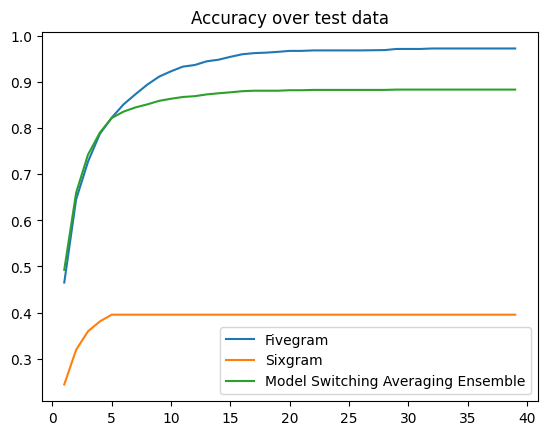

In [22]:
fivegram_plot_data = [(i, evaluate_fivegram(
    data,
    fivegram_model,
    output_set_size=i
)[0]) for i in range(1, 40)]

x_vals, y_vals_fivegram = zip(*fivegram_plot_data)

sixgram_plot_data = [(i, evaluate_sixgram(
    data,
    sixgram_model,
    output_set_size=i
)[0]) for i in range(1, 40)]

x_vals, y_vals_sixgram = zip(*sixgram_plot_data)

model_switching_ensemble_plot_data = [(i, evaluate_model_switching_ensemble(
    data,
    fivegram_model,
    sixgram_model,
    output_set_size=i
)[0]) for i in range(1, 40)]

x_vals, y_vals_model_switching_ensemble = zip(*model_switching_ensemble_plot_data)

plt.plot(x_vals, y_vals_fivegram, label='Fivegram')
plt.plot(x_vals, y_vals_sixgram, label='Sixgram')
plt.plot(x_vals, y_vals_model_switching_ensemble, label='Model Switching Averaging Ensemble')
plt.legend()
plt.title("Accuracy over test data")

plt.show()

## 2. LSTM Only

### Mounting LSTM and required files

In [23]:
import os
import tensorflow as tf
import numpy as np

# load lstm model
lstm_model = tf.keras.models.load_model('english-v1.h5', compile=False)
all_chars = np.load(os.path.join(os.getcwd(), 'encoded_chars.npy'))
type_chars = len(all_chars)
encoded = dict((c, i) for i, c in enumerate(all_chars))

### Aux data

In [24]:
"""aux_values.py"""

alphabet_to_dots = {
    ' ': 0,
    "a"	: 1,
    "b"	: 12,
    "c"	: 14,
    "d"	: 145,
    "e"	: 15,
    "f"	: 124,
    "g"	: 1245,
    "h"	: 125,
    "i"	: 24,
    "j"	: 245,
    "k"	: 13,
    "l"	: 123,
    "m"	: 134,
    "n"	: 1345,
    "o"	: 135,
    "p"	: 1234,
    "q"	: 12345,
    "r"	: 1235,
    "s"	: 234,
    "t"	: 2345,
    "u"	: 136,
    "v"	: 1236,
    "w"	: 2456,
    "x"	: 1346,
    "y"	: 13456,
    "z"	: 1356,
}

dots_to_alphabet = {
    0: " ",
    1: "a"	,
    12: "b"	,
    14: "c"	,
    145: "d"	,
    15: "e"	,
    124: "f"	,
    1245: "g"	,
    125: "h"	,
    24: "i"	,
    245: "j"	,
    13: "k"	,
    123: "l"	,
    134: "m"	,
    1345: "n"	,
    135: "o"	,
    1234: "p"	,
    12345: "q"	,
    1235: "r"	,
    234: "s"	,
    2345: "t"	,
    136: "u"	,
    1236: "v"	,
    2456: "w"	,
    1346: "x"	,
    13456: "y"	,
    1356: "z"	,
}

dots_to_unicode = {
    0: 0x2800,
    1: 0x2801,
    12: 0x2803,
    14: 0x2809,
    145: 0x2819,
    15: 0x2811,
    124: 0x280B,
    1245: 0x281B,
    125: 0x2813,
    24: 0x280A,
    245: 0x281A,
    13: 0x2805,
    123: 0x2807,
    134: 0x280D,
    1345: 0x281D,
    135: 0x2815,
    1234: 0x280F,
    12345: 0x281F,
    1235: 0x2817,
    234: 0x280E,
    2345: 0x281E ,
    136: 0x2825,
    1236: 0x2827,
    2456: 0x283A,
    1346: 0x282D,
    13456: 0x283D,
    1356: 0x2835,
}

unicode_to_dots = {
    0x2800: 0,
    0x2801: 1,
    0x2803: 12,
    0x2809: 14,
    0x2819: 145,
    0x2811: 15,
    0x280B: 124,
    0x281B: 1245,
    0x2813: 125,
    0x280A: 24,
    0x281A: 245,
    0x2805: 13,
    0x2807: 123,
    0x280D: 134,
    0x281D: 1345,
    0x2815: 135,
    0x280F: 1234,
    0x281F: 12345,
    0x2817: 1235,
    0x280E: 234,
    0x281E : 2345,
    0x2825: 136,
    0x2827: 1236,
    0x283A: 2456,
    0x282D: 1346,
    0x283D: 13456,
    0x2835: 1356,
}

### Aux functions

In [25]:
"""aux_functions.py"""

import re

def toBraille(c):

    engTable = {
        'a': "dots-1", 'b': "dots-12", 'c': "dots-14",
        'd': "dots-145", 'e': "dots-15", 'f': "dots-124",
        'g': "dots-1245", 'h': "dots-125", 'i': "dots-24",
        'j': "dots-245", 'k': "dots-13", 'l': "dots-123",
        'm': "dots-134", 'n': "dots-1345", 'o': "dots-135",
        'p': "dots-1234", 'q': "dots-12345", 'r': "dots-1235",
        's': "dots-234", 't': "dots-2345", 'u': "dots-136",
        'v': "dots-1236", 'w': "dots-2456", 'x': "dots-1346",
        'y': "dots-13456", 'z': "dots-1356", ' ': "space"
    }

    return engTable[c]

""" below is above as clean_text_for_lstm(), in step 0"""

# def clean_text(text):
#     cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
#     cleaned_text = cleaned_text.lower()
#     cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
#     return cleaned_text

def encode_char(c, enc):
    if c in enc:
        return enc[c]
    return enc['0']

### Predicting with LSTM

#### Implementation from API / backend

NB: for the backend implementation, the LSTM takes longer the longer input is given (not the case for fivegram and sixgram models) so take this into account during optimization.

In [26]:
"""Implementation used in API"""

def predict_text(text, model, all_chars, type_chars, encoded):
    x = np.array([encode_char(str(dots_to_unicode[alphabet_to_dots[c]]), encoded) for c in text])
    x = x.reshape((1, len(x), 1))
    pred = model.predict(x, verbose=0)
    pred = pred.reshape(type_chars, )
    print(f"Given text: {text}")
    print(f"Raw pred: {pred}")
    argsortI = np.argsort(pred)
    print("Top 5 predicted letters")
    ret = ""
    for i in range(5):
        ind = argsortI[-i-1]
        unicode_of_pred_braille = int(all_chars[ind])
        if unicode_of_pred_braille in unicode_to_dots and unicode_to_dots[unicode_of_pred_braille] in dots_to_alphabet:
            pred_char = dots_to_alphabet[unicode_to_dots[unicode_of_pred_braille]]
        else:
            pred_char = " "
        print(f"{pred_char} : {pred[ind]}")
        ret += pred_char
        ret += ' '
        ret += toBraille(pred_char)
        ret += '\n'

    return ret

#### Implementation for testing

In [27]:
"""Implementation here, for testing"""

def predict_text_lstm(text, model, all_chars, type_chars, encoded):
    # Encode the input text using the provided function and reshape for model input
    x = np.array([encode_char(str(dots_to_unicode[alphabet_to_dots[c]]), encoded) for c in text])
    x = x.reshape((1, len(x), 1))

    # Make predictions using the LSTM model
    pred = model.predict(x, verbose=0)

    # Reshape the predictions to a one-dimensional array
    pred = pred.reshape(type_chars, )

    # Print the input text and raw predictions
    # print(f"Given text: {text}")
    # print(f"Raw pred: {pred}")

    # Get the indices that would sort the predictions in ascending order
    argsortI = np.argsort(pred)

    # Print the top 5 predicted letters along with their probabilities
    # print("Top 5 predicted letters")

    # Initialize an empty list to store character-probability pairs
    predictions_list = []

    # Loop through the top 5 predictions
    for i in range(5):
        ind = argsortI[-i-1]
        unicode_of_pred_braille = int(all_chars[ind])

        # Convert Unicode to corresponding character using provided mappings
        if unicode_of_pred_braille in unicode_to_dots and unicode_to_dots[unicode_of_pred_braille] in dots_to_alphabet:
            pred_char = dots_to_alphabet[unicode_to_dots[unicode_of_pred_braille]]
        else:
            pred_char = " "

        # Print the character and its probability
        # print(f"{pred_char} : {pred[ind]}")

        # Append character and probability to the list
        predictions_list.append([pred_char, pred[ind]])

    # Return the list of character-probability pairs
    return predictions_list

In [28]:
cleaned_text = clean_text_for_lstm(data)[:61]

pred = predict_text_lstm("german carmaker pors", lstm_model, all_chars, type_chars, encoded)

print(f"Actual char: '{cleaned_text[60]}'")
print(pred)

Actual char: ' '
[['o', 0.451374], ['s', 0.19037893], [' ', 0.117927454], ['i', 0.06689985], ['e', 0.054615654]]


### Adding temperature for variation

A temperature of:
- 1: will not have an effect on the data
- \>1: will make the output more diverse but may reduce accuracy
- <1: will make the output more focused, but can reduce diversity

In [29]:
import math

def sample_with_temperature(predicted, temperature=1.0):
    sum_before = sum([a[1] for a in predicted])
    temp = []
    result = []
    sum_after = 0

    for char, prob in predicted:
        prob = math.log(prob) / temperature
        exp_prob = math.exp(prob)

        temp.append([char, exp_prob])
        sum_after += exp_prob

    for char, prob in temp:
        prob /= sum_after
        prob *= sum_before
        result.append([char, prob])

    return sorted(result, key=lambda x: x[1], reverse=True)

print(f"Before temperature: {pred}")
print(f"After temperature: {sample_with_temperature(pred, temperature=1.3)}")

Before temperature: [['o', 0.451374], ['s', 0.19037893], [' ', 0.117927454], ['i', 0.06689985], ['e', 0.054615654]]
After temperature: [['o', 0.3834401665296528], ['s', 0.19737830623643643], [' ', 0.13655146574236868], ['i', 0.08829164679267618], ['e', 0.07553430262210657]]


### Evaluating LSTM

In [ ]:
def evaluate_single_lstm(text, lstm_model, all_chars, type_chars, encoded, input_seq_length = 20, output_set_size=5, temperature=1.0, sample_size=-1):
    text = clean_text_for_lstm(text)
    datapoints = format_to_lstm(text, seq_length=input_seq_length)

    correct_predictions = 0
    total_predictions = 0

    for sequence in datapoints[:sample_size]:
        X = sequence[:input_seq_length-1]
        y = sequence[input_seq_length-1]

        pred = predict_text_lstm(X, lstm_model, all_chars, type_chars, encoded)
        pred = sample_with_temperature(pred, temperature)

        total_predictions += 1

        yhat = [i[0] for i in pred]
        yhat_probabilities = [i[1] for i in pred]

        if y in yhat:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions

    print(f'Length {input_seq_length} done')

    return (accuracy, total_predictions, correct_predictions)


evaluate_single_lstm(
    data,
    lstm_model,
    all_chars,
    type_chars,
    encoded,
    sample_size=1000,
    input_seq_length=5
)

[['o', 0.42114797], ['s', 0.18892123], [' ', 0.13800424], ['y', 0.06603207], ['e', 0.05886418]]
[['n', 0.639705], ['l', 0.080965385], ['s', 0.07481452], ['t', 0.044445686], ['r', 0.039915204]]
[['i', 0.6139288], [' ', 0.2699551], ['t', 0.04680084], ['c', 0.029128594], ['d', 0.0080689415]]
[['a', 0.27924943], ['e', 0.22130786], ['c', 0.09530067], ['d', 0.051004995], ['i', 0.049802165]]
[['o', 0.64803964], ['a', 0.27403218], ['r', 0.024941634], ['l', 0.018058268], ['e', 0.013271907]]
[['n', 0.6162808], ['r', 0.19821143], ['m', 0.0802883], ['l', 0.0406176], ['s', 0.020911098]]
[['r', 0.6773259], ['d', 0.14717275], ['s', 0.04480378], ['t', 0.032989457], ['e', 0.019411802]]
[['i', 0.4712526], ['e', 0.25387296], ['s', 0.065072], ['y', 0.05053845], [' ', 0.025994293]]
[['r', 0.46178174], ['t', 0.18357472], ['l', 0.08070206], ['b', 0.05712943], ['i', 0.04383851]]
[['e', 0.88773525], ['i', 0.10677752], [' ', 0.0024939328], ['s', 0.001811047], ['n', 0.00049738126]]
Length 5 done


(0.6, 10, 6)

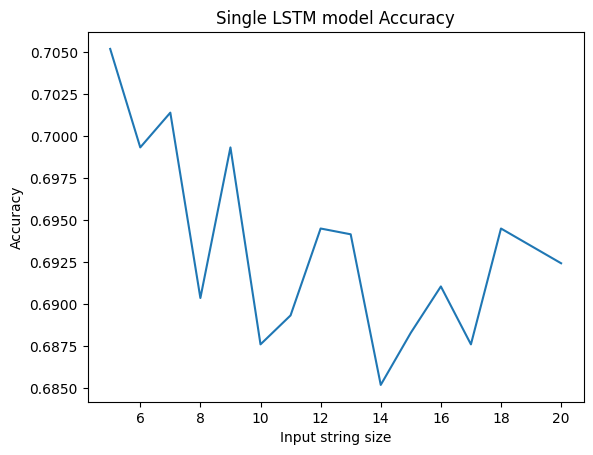

In [ ]:
single_lstm_plot_data = [(i, evaluate_single_lstm(
    data,
    lstm_model,
    all_chars,
    type_chars,
    encoded,
    input_seq_length=i
)[0]) for i in range(5, 21)]

x_vals, y_vals_single_lstm = zip(*single_lstm_plot_data)

import matplotlib.pyplot as plt

plt.plot(x_vals, y_vals_single_lstm)
plt.xlabel('Input string size')
plt.ylabel('Accuracy')
plt.title('Single LSTM model Accuracy')
plt.show()

## 3. Multiple LSTMs

### Test with two learners of varying input sequence length

In [ ]:
def evaluate_multiple_lstm(text, lstm_model, all_chars, type_chars, encoded, input_seq_lengths = [5, 12], output_set_size=5, temperature=1.0, sample_size=-1):
    text = clean_text_for_lstm(text)
    datapoints = format_to_lstm(text, seq_length=max(input_seq_lengths))

    correct_predictions = 0
    total_predictions = 0

    for sequence in datapoints[:sample_size]:
        Xs = [sequence[-1*l:-1] for l in input_seq_lengths]
        y = sequence[-1]

        preds = [predict_text_lstm(Xs[i], lstm_model, all_chars, type_chars, encoded) for i in range(len(Xs))]
        preds = [sample_with_temperature(preds[i], temperature) for i in range(len(Xs))]

        new_pred = []
        for pred in preds:
            new_pred += pred

        new_pred = sorted(new_pred, key=lambda x: x[1], reverse=True)
        pred = []
        checked_chars = set()

        for p in new_pred:
            if p[0] in checked_chars:
                pass
            else:
                checked_chars.add(p[0])
                pred.append(p)

        total_predictions += 1

        yhat = [i[0] for i in pred]
        yhat_probabilities = [i[1] for i in pred]

        if y in yhat:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions

    print(f'Lengths {input_seq_lengths} done')

    return (accuracy, total_predictions, correct_predictions)

evaluate_multiple_lstm(
    data,
    lstm_model,
    all_chars,
    type_chars,
    encoded,
    sample_size=100
)

Lengths [5, 12] done


(0.74, 100, 74)

### Further analysis

Lengths [5, 10, 15] done
Lengths [5, 10, 16] done
Lengths [5, 10, 17] done
Lengths [5, 10, 18] done
Lengths [5, 10, 19] done
Lengths [5, 10, 20] done


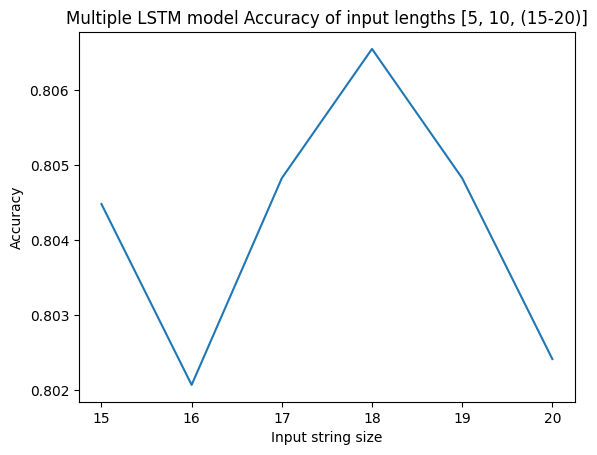

In [ ]:
multiple_lstm_plot_data = [(i, evaluate_multiple_lstm(
    data,
    lstm_model,
    all_chars,
    type_chars,
    encoded,
    input_seq_lengths=[5, 10, i]
)[0]) for i in range(15, 21)]

x_vals, y_vals_multiple_lstm = zip(*multiple_lstm_plot_data)

plt.plot(x_vals, y_vals_multiple_lstm)
plt.xlabel('Input string size')
plt.ylabel('Accuracy')
plt.title('Multiple LSTM model Accuracy of input lengths [5, 10, (15-20)]')
plt.show()

Lengths [5, 10] done
Lengths [5, 11] done
Lengths [5, 12] done
Lengths [5, 13] done
Lengths [5, 14] done
Lengths [5, 15] done
Lengths [5, 16] done
Lengths [5, 17] done
Lengths [5, 18] done
Lengths [5, 19] done
Lengths [5, 20] done


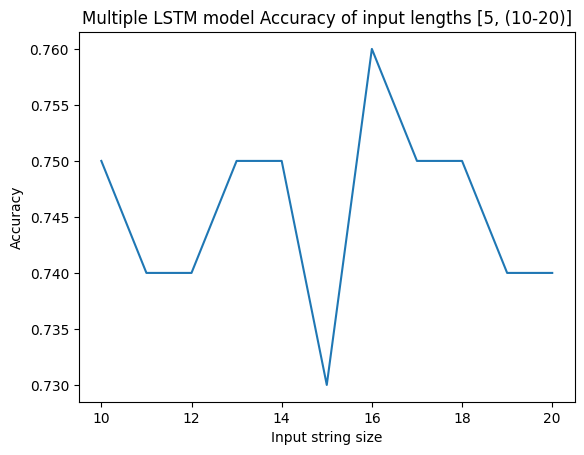

In [ ]:
multiple_lstm_plot_data = [(i, evaluate_multiple_lstm(
    data,
    lstm_model,
    all_chars,
    type_chars,
    encoded,
    sample_size=100,
    input_seq_lengths=[5, i]
)[0]) for i in range(10, 21)]

x_vals, y_vals_multiple_lstm = zip(*multiple_lstm_plot_data)

plt.plot(x_vals, y_vals_multiple_lstm)
plt.xlabel('Input string size')
plt.ylabel('Accuracy')
plt.title('Multiple LSTM model Accuracy of input lengths [5, (10-20)]')
plt.show()

## 4. Combining Fivegram, Sixgram and Ensemble LSTM methods

### Voting between Fivegram and Optimal LSTM

In [ ]:
def evaluate_voting_between_lstms_fivegram_ensemble(
    text,
    fivegram_model,
    lstm_model,
    all_chars,
    type_chars,
    encoded,
    input_seq_lengths_lstm = [5, 10, 18], # this was optimal from testing above
    output_set_size=5,
    temperature=1.0,
    sample_size=-1
):
    """
    NB: the data must NOT be formatted
    """

    # format data
    text = clean_text_for_lstm(text)
    datapoints = format_to_lstm(text, seq_length=max(input_seq_lengths_lstm))

    correct_predictions = 0
    total_predictions = 0

    for sequence in datapoints[:sample_size]:
        Xfivegram = sequence[-5:-1]
        Xlstms = [sequence[-1*l:-1] for l in input_seq_lengths_lstm]
        y = sequence[-1]

        in_fivegram = Xfivegram in fivegram_model

        # fivegram predictions

        if in_fivegram:

            yhat_fivegram = [pred[0] for pred in fivegram_model[Xfivegram][:output_set_size]]
            yhat_fivegram_probabilities = [pred[1] for pred in fivegram_model[Xfivegram][:output_set_size]]


        # multiple lstm predictions

        preds = [predict_text_lstm(Xlstms[i], lstm_model, all_chars, type_chars, encoded) for i in range(len(Xlstms))]
        preds = [sample_with_temperature(preds[i], temperature) for i in range(len(Xlstms))]

        new_pred = []
        for pred in preds:
            new_pred += pred

        new_pred = sorted(new_pred, key=lambda x: x[1], reverse=True)
        pred = []
        checked_chars = set()

        for p in new_pred:
            if p[0] in checked_chars:
                pass
            else:
                checked_chars.add(p[0])
                pred.append(p)

        yhat_multiple_lstm = [i[0] for i in pred]
        yhat_multiple_lstm_probabilities = [i[1] for i in pred]


        # combining the two for an ensemble method

        total_predictions += 1

        # only combine if fivegram exists
        if in_fivegram:
            yhat_zipped = list(zip(yhat_multiple_lstm, yhat_multiple_lstm_probabilities)) + list(zip(yhat_fivegram, yhat_fivegram_probabilities))
            yhat_dict = {}
            for char, prob in yhat_zipped:
                if char in yhat_dict:
                    yhat_dict[char] = max(prob, yhat_dict[char])
                else:
                    yhat_dict[char] = prob

            yhat = sorted(
                [[char, prob] for char, prob in yhat_dict.items()],
                key=lambda x: x[1],
                reverse=True
            )[:output_set_size]

            yhat_probabilities = [prob for _, prob in yhat]
            yhat = [char for char, _ in yhat]

            if y in yhat:
                correct_predictions += 1

        else:
            if y in yhat_multiple_lstm:
                correct_predictions += 1

    accuracy = correct_predictions / total_predictions

    return (accuracy, total_predictions, correct_predictions)




evaluate_voting_between_lstms_fivegram_ensemble(
    data,
    fivegram_model,
    lstm_model,
    all_chars,
    type_chars,
    encoded,
    temperature = 0.8,
    sample_size=200
)


(0.805, 200, 161)

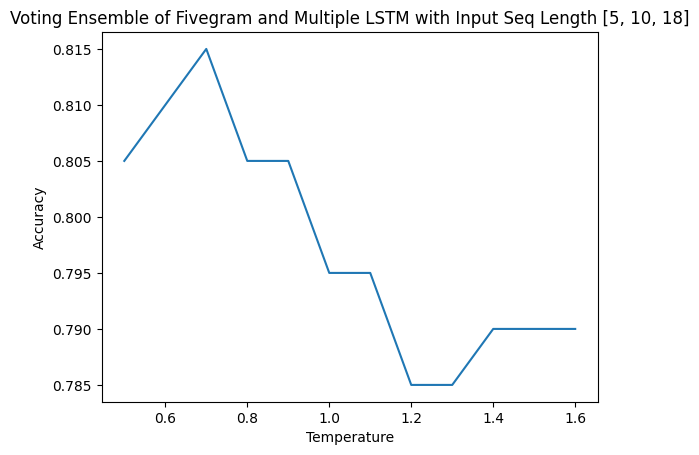

In [ ]:
voting_between_lstms_fivegram_ensemble_plot_data = [(i, evaluate_voting_between_lstms_fivegram_ensemble(
    data,
    fivegram_model,
    lstm_model,
    all_chars,
    type_chars,
    encoded,
    temperature=i,
    sample_size=200
)[0]) for i in np.arange(0.5, 1.6, 0.1)]

x_vals, y_vals_voting_between_lstms_fivegram_ensemble = zip(*voting_between_lstms_fivegram_ensemble_plot_data)

plt.plot(x_vals, y_vals_voting_between_lstms_fivegram_ensemble)
plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.title('Voting Ensemble of Fivegram and Multiple LSTM with Input Seq Length [5, 10, 18]')
plt.show()

### Combining LSTM and Fivegram (with Sixgram backup) with Random Forest Classifier



In [30]:
# seeing size of data available:

rfc_data = read_test_data("playData.txt")
rfc_data = clean_text_for_lstm(rfc_data)
len(rfc_data)

133070

In [31]:
# creating train and test data

seq_length = 20
rfc_data = format_to_lstm(rfc_data, seq_length=seq_length)
X = [d[:seq_length-1] for d in rfc_data]
y = [d[seq_length-1] for d in rfc_data]

test_data_size = len(X) // 10
train_data_size = len(X) - test_data_size

# NB: find better data and use cross validation maybe?
# X_train = X[:train_data_size]
# X_test = X[train_data_size:]
# y_train = y[:train_data_size]
# y_test = y[train_data_size:]

In [47]:
def format_and_predict_text_fivegram(texts, model, seq_length=20, output_length=5):
    all_predictions = []
    all_texts = []

    for text in format_to_lstm(clean_text_for_lstm(texts), seq_length):
        all_texts.append((text[:-1], text[-1]))
        X = text[:-1]
        y = text[-1]

        if X[-4:] in model:
            yhat = model[X[-4:]]

        all_predictions.append(yhat[:output_length])

    return all_texts, all_predictions

# format_and_predict_text_fivegram(
#     "Hello world this is an interesting example of a sentence that i thou",
#     fivegram_model
# )

In [48]:
def format_and_predict_text_lstm(texts, model, all_chars, type_chars, encoded, temperature=1.0, seq_length=20):
    # Initialize an empty list to store predictions for each input text
    all_predictions = []
    all_texts = []

    # Loop through each input text in the list
    for text in format_to_lstm(clean_text_for_lstm(texts), seq_length=seq_length):
        all_texts.append((text[:-1], text[-1]))

        # Encode the input text using the provided function and reshape for model input
        x = np.array([encode_char(str(dots_to_unicode[alphabet_to_dots[c]]), encoded) for c in text[:-1]])
        x = x.reshape((1, len(x), 1))

        # Make predictions using the LSTM model
        pred = model.predict(x, verbose=0)

        # Reshape the predictions to a one-dimensional array
        pred = pred.reshape(type_chars, )

        # Get the indices that would sort the predictions in ascending order
        argsortI = np.argsort(pred)

        # Initialize an empty list to store character-probability pairs for the current text
        predictions_list = []

        # Loop through the top 5 predictions
        for i in range(5):
            ind = argsortI[-i-1]
            unicode_of_pred_braille = int(all_chars[ind])

            # Convert Unicode to corresponding character using provided mappings
            if unicode_of_pred_braille in unicode_to_dots and unicode_to_dots[unicode_of_pred_braille] in dots_to_alphabet:
                pred_char = dots_to_alphabet[unicode_to_dots[unicode_of_pred_braille]]
            else:
                pred_char = " "

            # Append character and probability to the list
            predictions_list.append([pred_char, pred[ind]])

        # Append the list of predictions for the current text to the overall list
        all_predictions.append(sample_with_temperature(predictions_list, temperature=temperature))

    # Return the list of lists of character-probability pairs for each input text
    return all_texts, all_predictions

# format_and_predict_text_lstm(
#     "Hello world this is an interesting example of a sentence that i thou",
#     lstm_model,
#     all_chars,
#     type_chars,
#     encoded,
#     temperature=1.3
# )

In [56]:
# cleaning up fivegram model, there is a thing where in the inner most lists, the list is more than 2 long e.g. [' tha']

for sequence, probs in fivegram_model.items():
    # each probs is a list of lists
    new_probs = []
    for prob in probs:
        t = prob[:2]
        new_probs.append(t)

    fivegram_model[sequence] = new_probs

In [57]:
fivegram_model[' tha']

[['t', 0.668],
 ['n', 0.33],
 ['i', 0.002],
 ['w', 0.001],
 ['l', 0.0],
 [' ', 0.0],
 ['y', 0.0],
 ['r', 0.0],
 ['m', 0.0],
 ['b', 0.0],
 ['e', 0.0],
 ['s', 0.0],
 ['g', 0.0]]

In [70]:
import numpy as np

def create_feature_matrix(text, lstm_model, fivegram_model, all_chars, type_chars, encoded, input_seq_length=20):
    # Obtain predictions from LSTM and Fivegram models

    lstm_texts, lstm_predictions = format_and_predict_text_lstm(text, lstm_model, all_chars, type_chars, encoded, temperature=1.2, seq_length=input_seq_length)
    fivegram_texts, fivegram_predictions = format_and_predict_text_fivegram(text, fivegram_model, seq_length=input_seq_length)

    # Combine the LSTM and Fivegram predictions into a single feature matrix
    feature_matrix = []

    for lstm_text, lstm_preds in zip(lstm_texts, lstm_predictions):
        # Assuming lstm_text and fivegram_text are the same, modify if needed
        fivegram_preds = next(preds for fivegram_text, preds in zip(fivegram_texts, fivegram_predictions) if fivegram_text == lstm_text)

        # Extract relevant information
        input_sequence = lstm_text[0]
        actual_next_char = lstm_text[1]
        lstm_top_predictions = lstm_preds[:5]  # Take the top 5 predictions
        fivegram_top_predictions = fivegram_preds[:5]  # Take the top 5 predictions

        # Construct a feature vector
        feature_vector = [[input_sequence], [actual_next_char]] + [lstm_top_predictions] + [fivegram_top_predictions]

        # Append the feature vector to the feature matrix
        feature_matrix.append(feature_vector)

    return feature_matrix

create_feature_matrix(
    "Hello this is a test for me to check the thing",
    lstm_model,
    fivegram_model,
    all_chars,
    type_chars,
    encoded
)

[[['hello this is a tes'],
  ['t'],
  [[' ', 0.5763955175595364],
   ['s', 0.1820409063006123],
   ['t', 0.1337608542683172],
   ['p', 0.03074704975053553],
   ['d', 0.0227942372977238]],
  [['t', 0.996], ['s', 0.002], [' ', 0.001], ['l', 0.0], ['h', 0.0]]],
 [['ello this is a test'],
  [' '],
  [[' ', 0.7947066051863363],
   ['s', 0.13710978464331006],
   ['e', 0.022937358673084073],
   ['h', 0.01851327160278777],
   ['i', 0.014306439173273832]],
  [[' ', 0.458], ['i', 0.25], ['s', 0.199], ['e', 0.053], ['a', 0.022]]],
 [['llo this is a test '],
  ['f'],
  [['p', 0.24952508131922763],
   ['s', 0.10457987482615849],
   ['a', 0.09893870102583818],
   ['o', 0.0829979241674868],
   ['r', 0.06215076028697926]],
  [['i', 0.114], ['h', 0.101], ['a', 0.098], ['t', 0.096], ['p', 0.066]]],
 [['lo this is a test f'],
  ['o'],
  [['r', 0.44850315888780956],
   ['o', 0.3859120391633085],
   ['u', 0.04867035653722024],
   ['a', 0.042504289153681124],
   ['i', 0.034886526786320954]],
  [['o', 0.43],

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming 'feature_matrix' is the output of your function
feature_matrix = create_feature_matrix(
    "Hello this is a test for me to check the thing",
    lstm_model,
    fivegram_model,
    all_chars,
    type_chars,
    encoded
)

feature_matrix = np.array(feature_matrix)

# Extract features (X) and labels (y)
X = feature_matrix[:, 2:]  # Exclude the input sequence and actual next char
y = np.array([0 if i[1] == ' ' else 1 for i in feature_matrix])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the random forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (27, 4) + inhomogeneous part.

## 5. Final Testing

### Getting results for charts

In [ ]:
"""bar chart"""

data = read_test_data('newsData.txt')

categories = [
    "Fivegram",
    "Sixgram",
    "Weighted Average of Fivegram and Sixgram (3:1)",
    "Voting between Fivegram and Sixgram",
    "Single LSTM of Input Length 5",
    "Single LSTM of Input Length 5 with 0.8 Temperature",
    "Single LSTM of Input Length 5 with 1.2 Temperature",
    "Single LSTM of Input Length 5 with 1.5 Temperature",
    "Multiple LSTMs of Input Lengths [5, 20]",
    "Multiple LSTMs of Input Lengths [5, 10, 18]",
    "Voting Ensemble of Fivegram and Multiple LSTM [5, 10, 18] with temperature 0.8"
]

# all output set sizes are 5 as a control variable for the use case of the API
results = [
    evaluate_fivegram(
        data,
        fivegram_model,

    ),
    evaluate_sixgram(
        data,
        sixgram_model
    ),
    evaluate_weighted_averaging_ensemble(
        data,
        fivegram_model,
        sixgram_model,
        weight_fivegram=0.9,
        weight_sixgram=0.3
    ),
    evaluate_model_switching_ensemble(
        data,
        fivegram_model,
        sixgram_model
    ),
    evaluate_single_lstm(
        data,
        lstm_model,
        all_chars,
        type_chars,
        encoded,
        input_seq_length=5,
        temperature=1.0,
        sample_size=500
    ),
    evaluate_single_lstm(
        data,
        lstm_model,
        all_chars,
        type_chars,
        encoded,
        input_seq_length=5,
        temperature=0.8,
        sample_size=500
    ),evaluate_single_lstm(
        data,
        lstm_model,
        all_chars,
        type_chars,
        encoded,
        input_seq_length=5,
        temperature=1.2,
        sample_size=500
    ),evaluate_single_lstm(
        data,
        lstm_model,
        all_chars,
        type_chars,
        encoded,
        input_seq_length=5,
        temperature=1.5,
        sample_size=500
    ),
    evaluate_multiple_lstm(
        data,
        lstm_model,
        all_chars,
        type_chars,
        encoded,
        input_seq_lengths=[5, 20],
        sample_size=500
    ),
    evaluate_multiple_lstm(
        data,
        lstm_model,
        all_chars,
        type_chars,
        encoded,
        input_seq_lengths=[5, 10, 18],
        sample_size=500
    ),
    evaluate_voting_between_lstms_fivegram_ensemble(
        data,
        fivegram_model,
        lstm_model,
        all_chars,
        type_chars,
        encoded,
        temperature = 0.8,
        sample_size=500
    )
]

Length 5 done
Length 5 done
Length 5 done
Length 5 done
Lengths [5, 20] done
Lengths [5, 10, 18] done


### Sorting accuracies and displaying

[0.8227715877437326, 0.39540072078256394, 0.625, 0.8220132358063392, 0.688, 0.688, 0.688, 0.688, 0.772, 0.794, 0.796]
['Fivegram', 'Sixgram', 'Weighted Average of Fivegram and Sixgram (3:1)', 'Voting between Fivegram and Sixgram', 'Single LSTM of Input Length 5', 'Single LSTM of Input Length 5 with 0.8 Temperature', 'Single LSTM of Input Length 5 with 1.2 Temperature', 'Single LSTM of Input Length 5 with 1.5 Temperature', 'Multiple LSTMs of Input Lengths [5, 20]', 'Multiple LSTMs of Input Lengths [5, 10, 18]', 'Voting Ensemble of Fivegram and Multiple LSTM [5, 10, 18] with temperature 0.8']


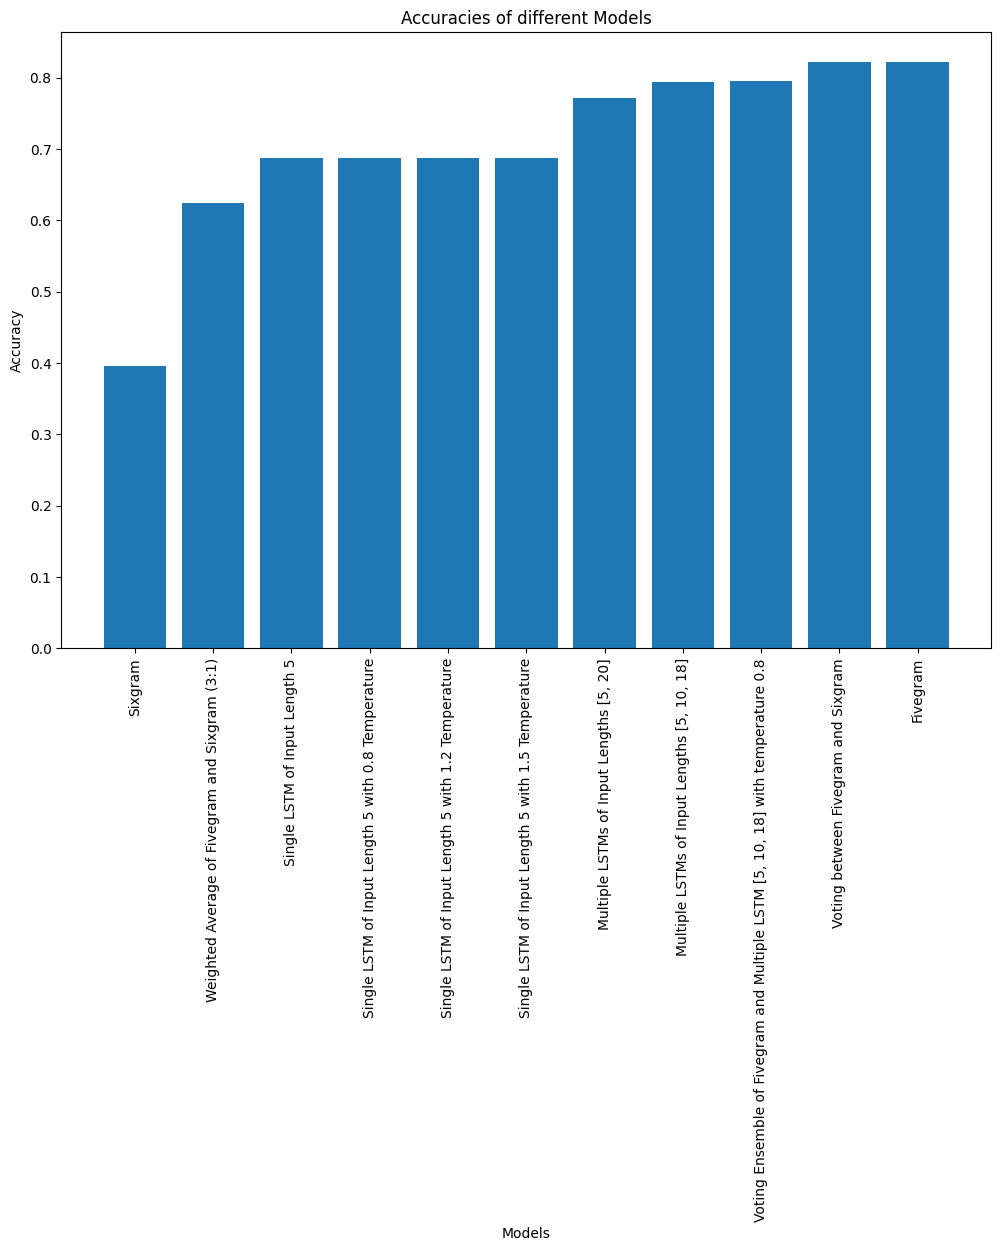

In [ ]:
import matplotlib.pyplot as plt

model_accuracies = [result[0] for result in results]
print(model_accuracies)
model_total_predictions = [result[1] for result in results]
print(categories)
model_correct_predictions = [result[2] for result in results]

accuracy_pairs = sorted(
    list(zip(categories, model_accuracies)),
    key=lambda x: x[1],
    reverse=False
)

sorted_accuracies = [pair[1] for pair in accuracy_pairs]
sorted_categories = [pair[0] for pair in accuracy_pairs]

plt.figure(figsize=(12,8))
plt.bar(sorted_categories, sorted_accuracies)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracies of different Models")
plt.xticks(rotation=90)
plt.show()

### Displaying total and correct predictions

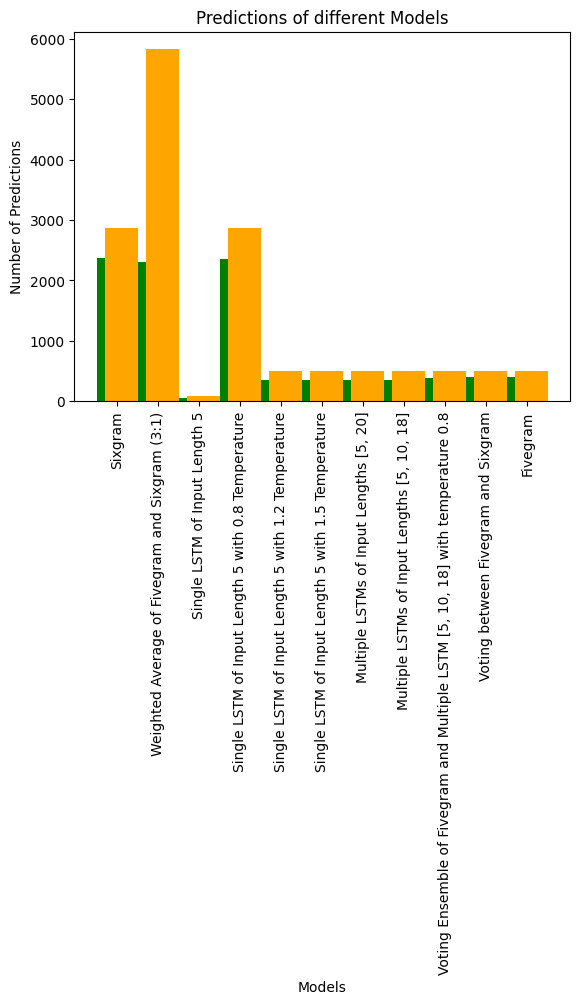

In [ ]:
bar_width = 0.2

correct_positions = np.arange(len(sorted_categories))
total_positions = correct_positions + bar_width


plt.bar(correct_positions, model_correct_predictions, label="Correct Predictions", color="green")
plt.bar(total_positions, model_total_predictions, label="Total Predictions", color="orange")
plt.xlabel("Models")
plt.ylabel("Number of Predictions")
plt.title("Predictions of different Models")
plt.xticks(correct_positions + bar_width / 2, sorted_categories, rotation=90)
plt.show()